<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/main/Colour_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !make -C sparse_gaussian_elimination a.so

In [ ]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, jacobi #  solve_pde
from network2 import Model

import PIL
import pickle

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

100%|██████████| 170498071/170498071 [00:03<00:00, 54946044.89it/s]


Extracting ./cifar-10-python.tar.gz to .


In [ ]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20 #@param
H = 256 #@param
W = 256 #@param
epoch = 1000 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [ ]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

218 0


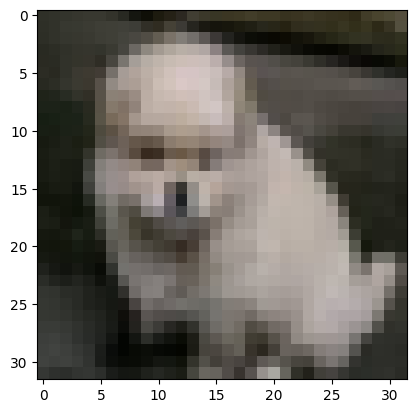

1.0 0.0


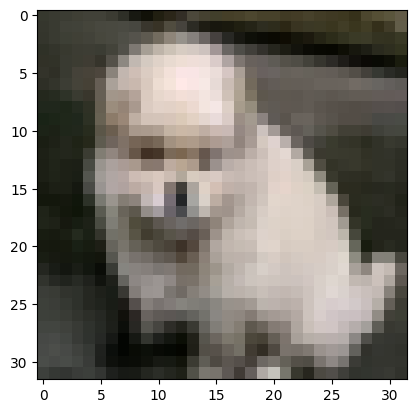

In [ ]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 32, 32)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(1):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 32, 32)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[i].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [ ]:
#@title Defining pde diffusion per thread
# import cupy as cp
# from cupyx.scipy.sparse import csr_matrix as cp_csr
# from cupyx.scipy.sparse import linalg as cp_linalg

def diffuse(initial_m, m, dm, channel, time_, g, scores):

  m[0, channel] = initial_m[channel]
  dh = 1 # 256/(H*W)

  # A_block = []
  for i in range(1, N):
    A_block = construct_A(H, W, dt/(2*dh), dt/(dh**2), 0, 0, g(time_[i]), scores[i, channel]) # A_block.append(sparse.csr_matrix(A))
    B_block = construct_B(H, W, m[i-1, channel])
    m[i, channel] = sparse.linalg.spsolve(sparse.csr_matrix(A_block), B_block).reshape((-1, H*W))

  # A_block = sparse.block_diag(A_block, format='csr')
  # A_block += sparse.diags(np.ones((N-1)*H*W)[H*W:], -H*W)
  # B_block = np.zeros(((N-1)*H*W))
  # B_block[:H*W] = construct_B(H, W, m[0, channel])

  # pde_sol = sparse.linalg.spsolve(A_block, B_block) # cp.asnumpy(cp_linalg.spsolve(cp_csr(A_block), cp.array(B_block)))
  # m[1:, channel] = pde_sol.reshape((-1, H*W))

  # del pde_sol
  # cp._default_memory_pool.free_all_blocks()

  img_log_prob = m[:, channel]
  dm[:, channel, 1:-1] = (img_log_prob[:, 2:] - img_log_prob[:, :-2])/(2*dh) # (img_log_prob[:, 1:-1, 2:] - img_log_prob[:, 1:-1, :-2])/(2*dy)
  dm[:, channel, 0] = (img_log_prob[:, 1] - 0)/(2*dh) #+ (img_log_prob[:, 1:-1, 0] - img_log_prob[:, 1:-1, -1])/dy
  dm[:, channel, -1] = (0 - img_log_prob[:, -2])/(2*dh) #+ (img_log_prob[:, 1:-1, -1] - img_log_prob[:, 1:-1, 0])/dy
  # dm[:, channel, 0 , 1:-1] = (img_log_prob[:, 0, 2:] - img_log_prob[:, 0, :-2])/(2*dy) + (img_log_prob[:, 0, 1:-1] - img_log_prob[:, -1, 1:-1])/dx
  # dm[:, channel, -1 , 1:-1] = (img_log_prob[:, -1, 2:] - img_log_prob[:, -1, :-2])/(2*dy) + (img_log_prob[:, -1, 1:-1] - img_log_prob[:, 0, 1:-1])/dx

In [ ]:
from torch.utils.data import Dataset
from torchvision.transforms import v2

class CelebDataset(Dataset):
  def __init__(self, H, W, n=3, seed=None):
    with open(os.path.join('/content/', 'celeb_data.pkl'), 'br') as f:
      data = pickle.load(f)
    self.transform = v2.Compose([
      v2.ToImage(),
      v2.Resize((W, H), interpolation=v2.InterpolationMode.BICUBIC, antialias=True)
    ])
    if n == 1:
      self.data = [self.transform(data[-3])]
    else:
      self.data = [self.transform(img) for img in data[:n]]
    self.channels = 3

    self.data = [(raw - raw.min())/(raw.max() - raw.min()) for raw in self.data]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [ ]:
data_tensor = CelebDataset(H, W, n=1)

In [ ]:
#@title Precompute score labels by solving the PDE
def parrallel_score_samples(kde, samples, thread_count=int(0.875 * multiprocessing.cpu_count())):
    with multiprocessing.Pool(thread_count) as p:
        return np.concatenate(p.map(kde.score_samples, np.array_split(samples, thread_count)))

tol = 1e-3 #@param
max_iter = 1000 #@param

if not os.path.exists('scores_label'):
  scores_label = []
  init_m_batch = []
  for idx, data in tqdm(enumerate(data_tensor)):
    y_train = []
    for j in range(H):
      y_train.append(data[:, j, :])
    y_train = np.concatenate(y_train, axis=-1)

    x_train = []
    for l in range(W):
      x_train.append(data[:, :, l])
    x_train = np.concatenate(x_train, axis=1)
    init_m = []
    for ch in range(channels):
      xy_train = np.vstack([x_train[ch], y_train[ch]])
      kde = KernelDensity(bandwidth='scott', kernel='linear', algorithm='kd_tree').fit(xy_train.T)
      kde_log_pdf = parrallel_score_samples(kde, xy_train.T)
      init_m.append(kde_log_pdf[None])

    init_m = np.concatenate(init_m)
    init_m_batch.append(init_m[None])
  init_m_batch = np.concatenate(init_m_batch)

  for idx, data in enumerate(data_tensor):

    m = np.zeros((N, channels, H*W), dtype=np.float32)
    m_prev = np.zeros((N, channels, H*W), dtype=np.float32)
    scores = np.zeros((N, channels, H*W), dtype=np.float32) # initial scores guess
    dm = np.zeros_like(scores, dtype=np.float32)

    res = 1
    e = 0
    while res > tol:
      res_prev = res
      # we want to sample from random time steps to construct training samples
      time_ = np.linspace(eps, 1., N) + idx
      print(time_.max(), time_.min())
      # diffuse all three channels concurrently
      for ch in tqdm(range(channels)):
        diffuse(init_m_batch[idx], m, dm, ch, time_, diffusion_coeff_fn, scores)

      scores = dm.copy()

      if e == max_iter:
        print(f'No convergence')
        break

      res = np.linalg.norm(m - m_prev)
      print(f'residual at iteration {e}: {res}')

      m_prev = m.copy()
      e += 1

      if abs(res_prev - res) < 1e-6:
        break

    scores_label.append(scores.copy().reshape((1, -1, channels, H, W)))
  scores_label = np.concatenate(scores_label) + eps
  print(scores_label.shape)

1it [03:20, 200.28s/it]


1.0 1e-06


100%|██████████| 3/3 [39:09<00:00, 783.24s/it]


residual at iteration 0: 750.7418823242188
1.0 1e-06


100%|██████████| 3/3 [38:53<00:00, 777.97s/it]


residual at iteration 1: 8.183547019958496
1.0 1e-06


100%|██████████| 3/3 [38:51<00:00, 777.22s/it]


residual at iteration 2: 0.7892982363700867
1.0 1e-06


100%|██████████| 3/3 [38:46<00:00, 775.39s/it]


residual at iteration 3: 0.07137186080217361
1.0 1e-06


100%|██████████| 3/3 [38:44<00:00, 774.89s/it]


residual at iteration 4: 0.009634638205170631
1.0 1e-06


100%|██████████| 3/3 [38:30<00:00, 770.03s/it]

residual at iteration 5: 0.000901383871678263
(1, 20, 3, 256, 256)


1.8838387 -1.8063581


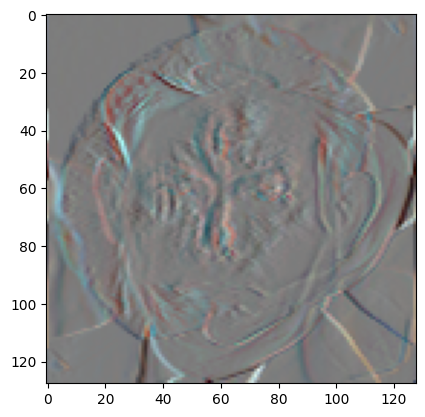

1.659575 -1.5103986


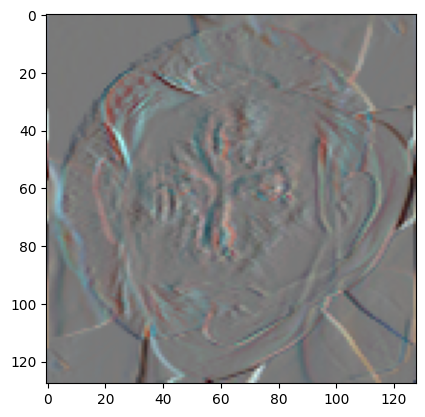

1.3874657 -1.2183113


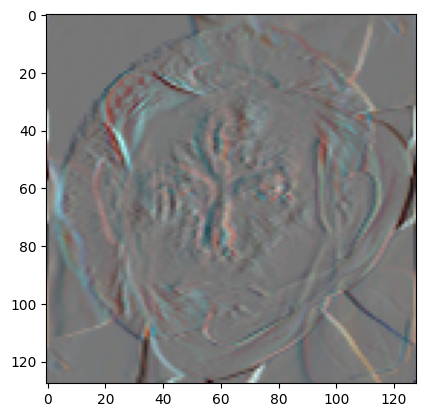

1.0963275 -1.0155563


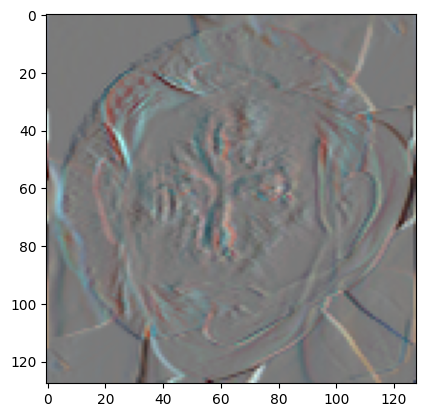

0.7978466 -0.77882385


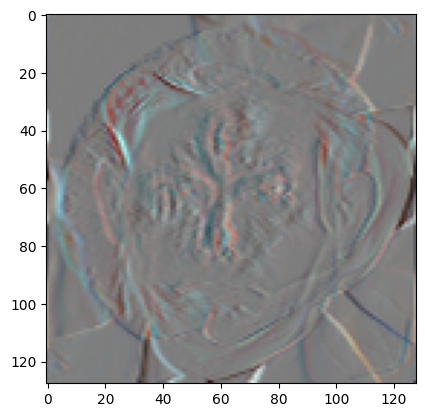

0.5298667 -0.5286495


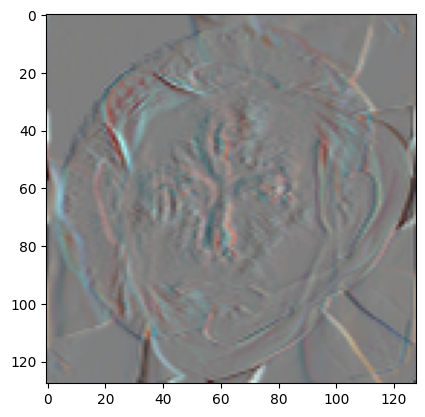

0.30375695 -0.30599546


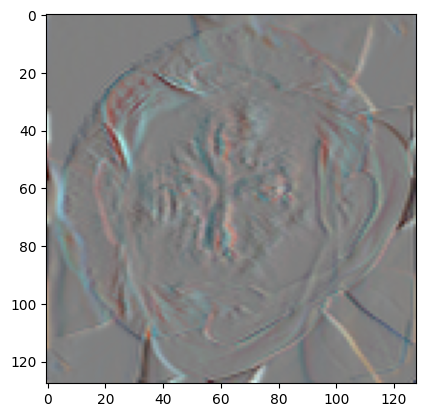

0.14107579 -0.14484473


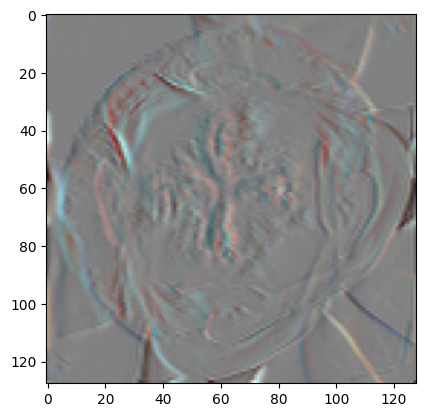

0.055482954 -0.053658076


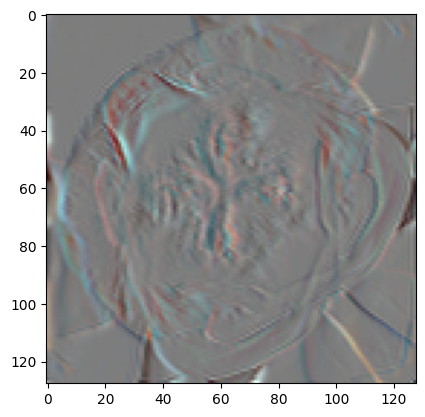

0.017905008 -0.014903385


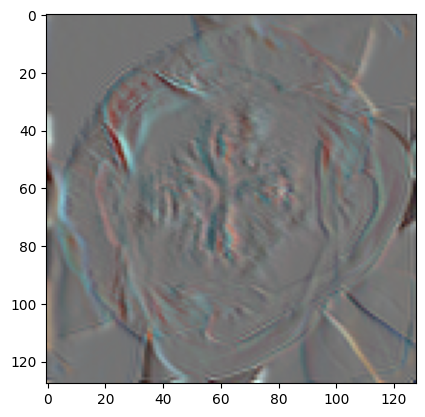

0.004522633 -0.003754877


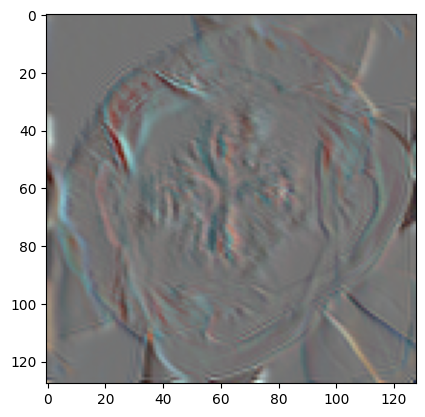

0.00080588 -0.00073657796


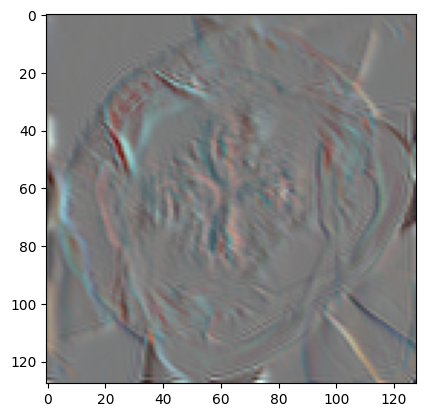

0.00011474221 -0.000103224455


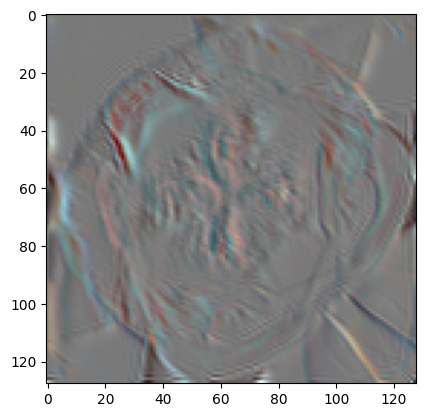

1.3116411e-05 -1.0166801e-05


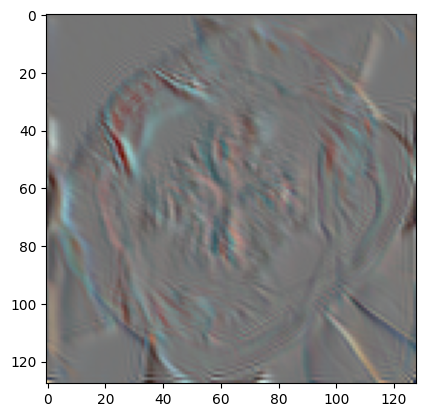

2.0341226e-06 1.518946e-07


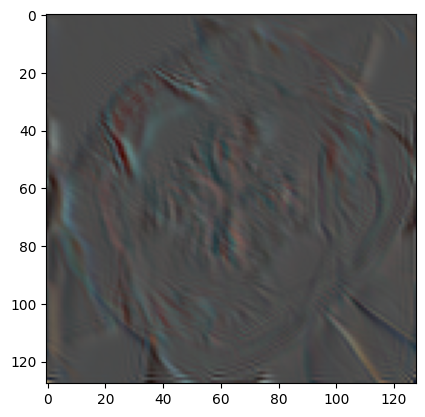

1.0630471e-06 9.548629e-07


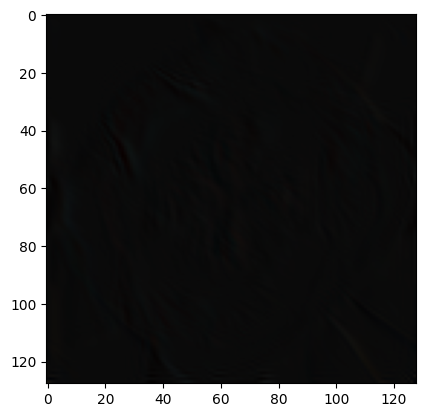

1.0027313e-06 9.980749e-07


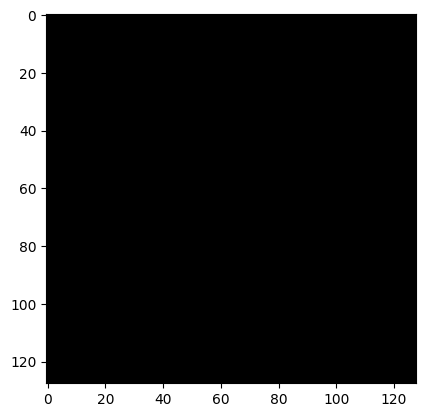

1.0000838e-06 9.999418e-07


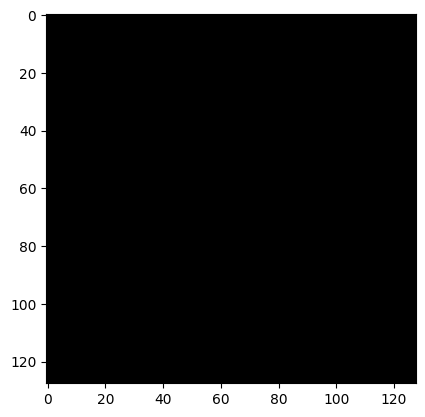

1.0000018e-06 9.999987e-07


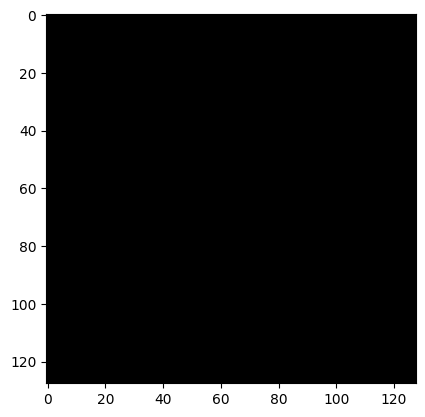

1e-06 1e-06


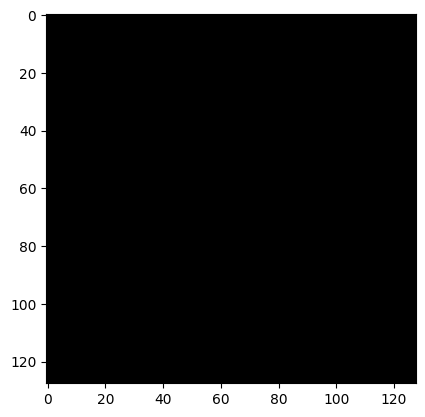

In [ ]:
#@title Show the score labels
if os.path.exists(f'scores_label'):
  with open('/content/scores_label', 'rb') as file:
    scores_label = pickle.load(file)

for idx in range(1):
  for i in range(N):
    print(scores_label[idx][i].max(), scores_label[idx][i].min())
    plt.imshow(((scores_label[idx][i] - scores_label[idx][i].min())/(scores_label[idx][i].max() - scores_label[idx][i].min() + eps)).transpose(1, 2, 0))
    plt.show()

In [ ]:
import pickle
if not os.path.exists('scores_label'):
  with open('/content/scores_label', 'wb') as file:
    pickle.dump(scores_label, file)

In [ ]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, idx=1, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps, 1., N)).astype(np.float32)) + idx
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * ((label[i-1] + label[i])/2) * diff_std2[i-1] * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [ ]:
#@title Function for training on a thread
def diffuse_train(init_x, epoch, diffusion_coeff, marginal_prob_std, label, losses, model_score, optimizer, idx=1):
  scores_label = torch.tensor(label)

  loss = loss_fn(model_score, init_x, scores_label, diffusion_coeff, marginal_prob_std, idx)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss)

In [ ]:
#@title Training the score-network
if os.path.exists(f'model_cifar.pth'):
  print(f'removing saved weights\n')
  os.remove(f'model_cifar.pth')

init_x = torch.zeros((N, channels, H, W))

model_score = Model()
optimizer = AdamW(model_score.parameters(), lr=lr)
model_score.train();

for e in tqdm(range(epoch)):
  losses = []
  for idx, data in enumerate(cifar_data_list_tensor):

    for i in range(N):
      init_x[i] = data

    diffuse_train(init_x, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label[idx], losses, model_score, optimizer, idx)

    print(f'\nloss: {losses[idx]}')

file = f'model_cifar.pth'
torch.save(model_score.state_dict(), file)
print(f"model has been saved\n")

  0%|          | 1/1000 [00:04<1:12:36,  4.36s/it]


loss: 4718.25634765625


  0%|          | 2/1000 [00:07<1:03:21,  3.81s/it]


loss: 5541.0693359375


  0%|          | 3/1000 [00:12<1:08:36,  4.13s/it]


loss: 4034.1875


  0%|          | 4/1000 [00:15<1:03:24,  3.82s/it]


loss: 3649.604736328125


  0%|          | 5/1000 [00:19<1:01:08,  3.69s/it]


loss: 4058.096923828125


  1%|          | 6/1000 [00:27<1:28:58,  5.37s/it]


loss: 3452.628173828125


  1%|          | 7/1000 [00:33<1:33:05,  5.62s/it]


loss: 3218.333740234375


  1%|          | 8/1000 [00:38<1:27:02,  5.26s/it]


loss: 3374.24267578125


  1%|          | 9/1000 [00:41<1:17:07,  4.67s/it]


loss: 3249.771240234375


  1%|          | 10/1000 [00:45<1:10:49,  4.29s/it]


loss: 3264.503173828125


  1%|          | 11/1000 [00:48<1:07:16,  4.08s/it]


loss: 3147.716552734375


  1%|          | 12/1000 [00:53<1:09:13,  4.20s/it]


loss: 3108.5283203125


  1%|▏         | 13/1000 [00:56<1:04:51,  3.94s/it]


loss: 3123.142333984375


  1%|▏         | 14/1000 [01:00<1:02:05,  3.78s/it]


loss: 3112.31494140625


  2%|▏         | 15/1000 [01:04<1:05:33,  3.99s/it]


loss: 2996.24609375


  2%|▏         | 16/1000 [01:08<1:05:20,  3.98s/it]


loss: 3017.486572265625


  2%|▏         | 17/1000 [01:11<1:02:33,  3.82s/it]


loss: 3040.719482421875


  2%|▏         | 18/1000 [01:16<1:04:56,  3.97s/it]


loss: 3029.260498046875


  2%|▏         | 19/1000 [01:19<1:02:12,  3.81s/it]


loss: 3080.557861328125


  2%|▏         | 20/1000 [01:22<59:50,  3.66s/it]  


loss: 2995.38818359375


  2%|▏         | 21/1000 [01:26<58:05,  3.56s/it]


loss: 2978.821533203125


  2%|▏         | 22/1000 [01:30<1:01:46,  3.79s/it]


loss: 2956.466064453125


  2%|▏         | 23/1000 [01:33<59:36,  3.66s/it]  


loss: 2935.594482421875


  2%|▏         | 24/1000 [01:37<58:05,  3.57s/it]


loss: 2921.48388671875


  2%|▎         | 25/1000 [01:41<1:01:54,  3.81s/it]


loss: 2977.677490234375


  3%|▎         | 26/1000 [01:45<59:36,  3.67s/it]  


loss: 2883.633544921875


  3%|▎         | 27/1000 [01:48<57:47,  3.56s/it]


loss: 2910.41064453125


  3%|▎         | 28/1000 [01:51<56:41,  3.50s/it]


loss: 2996.02685546875


  3%|▎         | 28/1000 [01:52<1:04:56,  4.01s/it]


KeyboardInterrupt: 

In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-4 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3,
                idx = 1):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device) + idx
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape
  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t + idx
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')

  print(f"\nNumber of function evaluations: {res.nfev}")
  x = []
  for i in range(res.y.shape[-1]):
    x.append(res.y[:, i].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [ ]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, samples, diffusion_coeff, marginal_prob_std, model, idx=1):

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size,
                  idx = idx)

  samples.append(output)

In [ ]:
#@title Sampling image
samples = []

model_score = Model()
file = f'model_cifar.pth'
ckpt = torch.load(file)
model_score.load_state_dict(ckpt)
model_score.eval();

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  diffuse_sample(data[None], samples, diffusion_coeff_fn, marginal_prob_std_fn, model_score, idx)
  # samples = np.concatenate(samples, axis = 1)
  for i in range(samples[idx].shape[0]):
    print(f'{samples[idx][i].mean(), samples[idx][i].std()}')
    plt.imshow(((samples[idx][i] - samples[idx][i].min())/(samples[idx][i].max() - samples[idx][i].min())).transpose(1, 2, 0))
    plt.show()